![Dynamat Banner](../docs/figures/banner.png)

# Johson-Cook Model Fit: Pre‑processing Pipeline

Authors: [Erwin Cazares<sup>1</sup>](ecazares3@miners.utep.edu), </br>

Contributors: [Dr Brian E. Schuster<sup>1</sup>](bschuster@utep.edu), [David K Santacruz<sup>1</sup>](dksantacruz@miners.utep.edu) </br>

<sup>1</sup> Dynamic Materials Laboratory at the University of Texas at El Paso, TX USA 79968</br>

Date of creation: Summer 2025 </br>
Date of last revision: Summer 2025 </br>

In [1]:
from pathlib import Path
import numpy as np
from scipy.signal.windows import tukey
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")
import pandas as pd
from datetime import datetime
import sys

nb_dir        = Path.cwd()                    # …/SHPB_Johnson_Cook/notebooks
proj_root     = nb_dir.parent                 # …/SHPB_Johnson_Cook
repo_root     = proj_root.parent              # one level higher

# ① SHPB_Johnson_Cook/scripts     (your new code)
jc_scripts    = proj_root / "scripts"
sys.path.insert(0, str(jc_scripts))

# ② SHPB_Toolkit/scripts          (original toolkit)
toolkit_path  = repo_root / "SHPB_Toolkit" / "scripts"
sys.path.insert(1, str(toolkit_path))         # keep as second–priority

# imports
from rdf_wrapper               import RDFWrapper                     # lives in toolkit
from SHPB_RDFSignalFetch       import RawExperimentDataHandler       # lives in JC scripts
from RDF_data_io               import find_experiments, summarise_specimens, fetch_raw_pulse
from SHPB_Pulse_Windows        import find_pulse_window, segment_and_center_pulse
from shift_optimizer           import shift_optimizer



## Discover the experiment records via SPARQL search
Matches specimen material and processsing method in all RDF saved experiments

In [3]:
root = Path(r"D:\DynaMat_UTEP\SHPB_Toolkit\data")

targets = find_experiments(root,
                           material_abbr="SS316",
                           processing_abbr="3D Printed Specimen", # "3D Printed Specimen", "Casted Specimen"
                           debug=False)          # file matcher log

print("\nSUMMARY:", len(targets), "files matched")
for p in targets:
    print(" •", p)

out_dir = Path("../pinn_dataset/SS316A356/npz")       # choose your folder
out_dir.mkdir(parents=True, exist_ok=True)




SUMMARY: 23 files matched
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250219_SS316_LAB_RT_001.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250219_SS316_LAB_RT_002.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430_SS316_LAB_RT_021.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430_SS316_LAB_RT_022.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430_SS316_LAB_RT_023.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_SS316_LAB_RT_009.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_SS316_LAB_RT_010.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250428_SS316_LAB_RT_016.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250428_SS316_LAB_RT_017.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429_SS316_LAB_RT_018.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429_SS316_LAB_RT_019.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429_SS316_LAB_RT_020.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250507_SS316_LAB_RT_024.ttl
 • D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250507_

In [19]:
targets = [r"D:\DynaMat_UTEP\SHPB_Toolkit\data\BES_20250825_STC350_LAB_RT_001.ttl"]

## Extract experiment dimensions
From matched RDF files, extract specimen original length (mm), area (mm2) and diameter (mm) to be saved on to the npz file.

In [4]:
spec_df = summarise_specimens(targets,
                              debug=False) # Prints Individual Specimen Properties
display(spec_df.head(10))

,file,length_mm,area_mm2,diameter_mm
0,D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250219...,6.43,32.47221,NaN
1,D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250219...,6.40,32.16991,NaN
2,D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430...,6.38,31.47004,6.33
3,D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430...,6.33,31.56955,6.34
4,D:\DynaMat_UTEP\SHPB_Toolkit\data\DKS_20250430...,6.37,31.47004,6.33
5,D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407...,6.42,32.57329,6.44
6,D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407...,6.44,32.37128,6.42
7,D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250428...,6.55,31.37069,6.32
8,D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250428...,6.38,31.47004,6.33
9,D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250429...,6.59,31.56955,6.34


## Extract strain gauge traces
Finds the strain gauge traces saved at the RDF file, looks for the Incident, Reflected and Time vectors

Current Working with D:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250529_SS316_LAB_RT_030.ttl
[raw_pulse] ECG_20250529_SS316_LAB_RT_030.ttl → 160000 samples


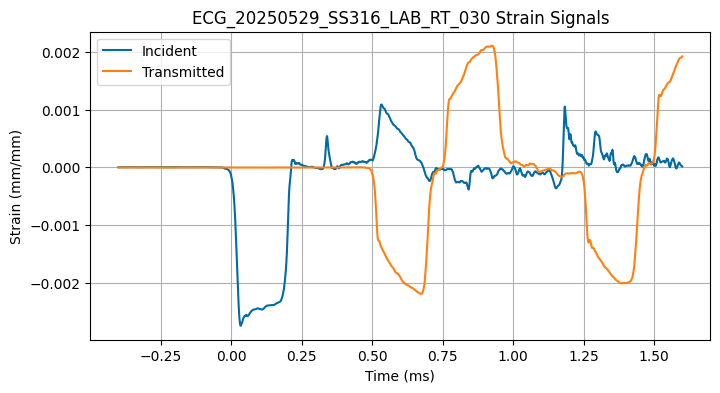

In [13]:
idx =-6   # Change this for each experiment!
print(f"Current Working with {targets[idx]}")

raw_df    = fetch_raw_pulse(targets[idx], debug=True)

# Plot returned signals
plt.figure(figsize=(8,4))
plt.plot(raw_df["Time"], raw_df["Incident Raw"], label = "Incident")
plt.plot(raw_df["Time"], raw_df["Transmitted Raw"], label = "Transmitted")
plt.title(f"{targets[idx].stem} Strain Signals")
plt.xlabel("Time (ms)")
plt.ylabel("Strain (mm/mm)")
plt.legend()
plt.grid()
plt.show()

## Segment Pulse Windows
Locate stress-pulse windows in a noisy Hopkinson-bar gauge trace using a matched-filter (cross-correlation of half-cosine wave) approach

In [14]:
# pulse duration data points 
pulse_pts = int(0.185/ np.median(np.diff(raw_df["Time"]))) # 0.185 ms for 18 in str 

# user-defined bounds – ignore detections outside bounds
LB, UB = 10000, 115000

incident_window = find_pulse_window(
    raw_df["Incident Raw"].values,
    pulse_points     = pulse_pts,
    k_trials         = (5000, 2000, 1000),
    polarity         = "compressive",
    min_separation   = 0.8*pulse_pts,
    lower_bound      = LB,
    upper_bound      = 50000,    
    metric           = "median",
    debug=False)

if not incident_window:
    raise RuntimeError("No incident pulse detected (matched filter)")

transmitted_window = find_pulse_window(
    raw_df["Transmitted Raw"].values,
    pulse_points     = pulse_pts,
    k_trials         = (1500, 1000, 800),
    polarity         = "compressive",
    min_separation   = 0.8*pulse_pts,
    lower_bound      = LB,
    upper_bound      = UB,
    metric           = "median",
    debug=False)

if not transmitted_window:
    raise RuntimeError("No transmitted pulse detected (matched filter)")

reflected_window = find_pulse_window(
    raw_df["Incident Raw"].values,
    pulse_points     = pulse_pts,
    k_trials         = (2800, 1500, 1000, 500),
    polarity         = "tensile",
    min_separation   = .60*pulse_pts,
    lower_bound      = LB,
    upper_bound      = UB,
    metric           = "median",
    debug=True)

if not reflected_window:
    raise RuntimeError("No reflected pulse detected (matched filter)")


[find_pulse_window] k_sigma = 2800
[matched] σ=2.68e-05 thr=7.50e-02  peaks=0
  → 0 window(s)

[find_pulse_window] k_sigma = 1500
[matched] σ=2.68e-05 thr=4.02e-02  peaks=9881
  window: pk=69593  idx=(62204,76982)  len=14778
  window: pk=78461  idx=(71072,85850)  len=14778
  → 2 window(s)

[find_pulse_window] k_sigma = 1000
[matched] σ=2.68e-05 thr=2.68e-02  peaks=17693
  window: pk=51929  idx=(44540,59318)  len=14778
  window: pk=68149  idx=(60760,75538)  len=14778
  window: pk=77017  idx=(69628,84406)  len=14778
  window: pk=127646  idx=(120257,135035)  len=14778
  → 4 window(s)

[find_pulse_window] k_sigma = 500
[matched] σ=2.68e-05 thr=1.34e-02  peaks=33977
  window: pk=50169  idx=(42780,57558)  len=14778
  window: pk=66802  idx=(59413,74191)  len=14778
  window: pk=75670  idx=(68281,83059)  len=14778
  window: pk=122900  idx=(115511,130289)  len=14778
  window: pk=131768  idx=(124379,139157)  len=14778
  → 5 window(s)
[window] selected idx=(71072, 85850)  median=5.4675e-04  (boun

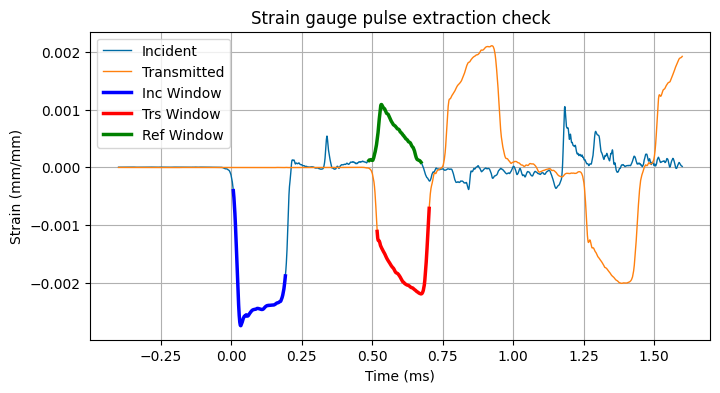

In [15]:
# window limits
inc_win = incident_window
trs_win = transmitted_window
ref_win = reflected_window

inc_sig  = raw_df["Incident Raw"].iloc[inc_win[0]:inc_win[1]].to_numpy()
trs_sig  = raw_df["Transmitted Raw"].iloc[trs_win[0]:trs_win[1]].to_numpy()
ref_sig  = raw_df["Incident Raw"].iloc[ref_win[0]:ref_win[1]].to_numpy()

i0, i1 = inc_win 
t0, t1 = trs_win 
r0, r1 = ref_win 

fig, ax = plt.subplots(figsize=(8, 4))

# full raw trace
ax.plot(raw_df["Time"], raw_df["Incident Raw"], lw=1, label="Incident")
ax.plot(raw_df["Time"], raw_df["Transmitted Raw"], lw=1, label="Transmitted")

# extracted pulse
ax.plot(raw_df["Time"].iloc[i0:i1], inc_sig, lw=2.5, label = "Inc Window", c = "b")
ax.plot(raw_df["Time"].iloc[t0:t1], trs_sig, lw=2.5, label = "Trs Window", c = "r")
ax.plot(raw_df["Time"].iloc[r0:r1], ref_sig, lw=2.5, label = "Ref Window", c = "g")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Strain (mm/mm)")
ax.legend()
ax.set_title("Strain gauge pulse extraction check")
ax.grid()
#plt.tight_layout()

## Center Pulse Window
Using the previous found pulse window, center the median amplitude over N-points

[segment & center] shift = -293 points
[segment & center] shift = -767 points
[segment & center] shift = +1247 points


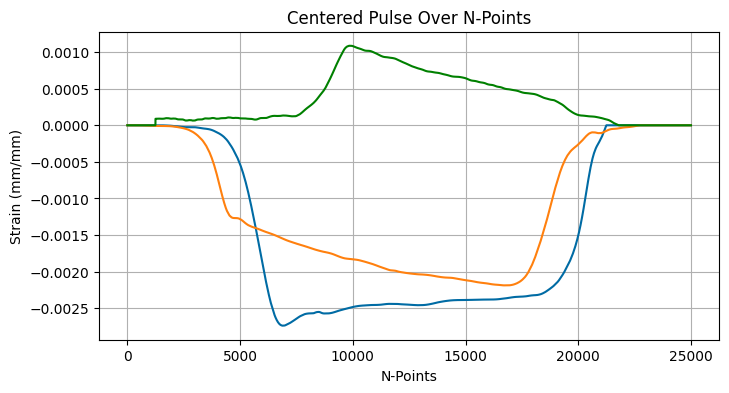

In [16]:
n_pts = 25000

inc_seg  = segment_and_center_pulse(
              raw_df["Incident Raw"].values,
              inc_win,
              n_points=n_pts,
              polarity="compressive",
              thresh_ratio = 0.0,
              debug=True
          )

trs_seg  = segment_and_center_pulse(
              raw_df["Transmitted Raw"].values,
              trs_win,
              n_points=n_pts,
              polarity="compressive",
              thresh_ratio = 0.0,
              debug=True
          )

ref_seg  = segment_and_center_pulse(
              raw_df["Incident Raw"].values,
              ref_win,
              n_points=n_pts,
              polarity="tensile",
              thresh_ratio = 0.00,
              debug=True
          )


time_seg = raw_df["Time"].iloc[:len(inc_seg)]    # same length

plt.figure(figsize=(8,4))
plt.plot(inc_seg, label = "Incident")
plt.plot(trs_seg, label = "Transmitted")
plt.plot(ref_seg, label = "Reflected", c = "green")
plt.title("Centered Pulse Over N-Points")
plt.xlabel("N-Points")
plt.ylabel("Strain (mm/mm)")
plt.grid()
plt.show()


## Align Pulse Fronts
Shift all pulses so their rise fronts correlate to the post-processing operations. Removes time and spatial shifts from sensor distances.

optimal shifts  Transmitted = +1398  Reflected = -2800  [samples]


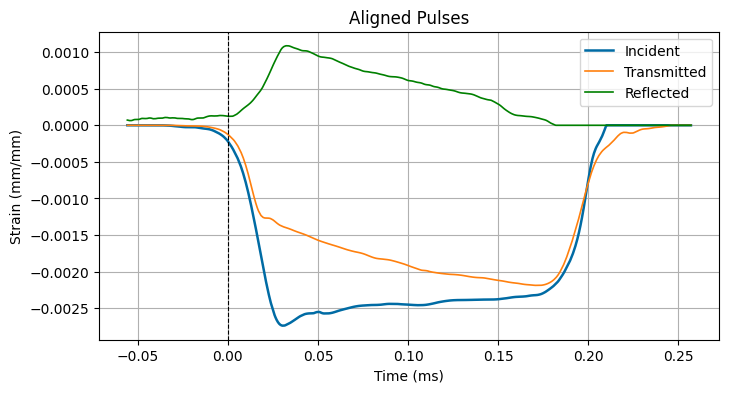

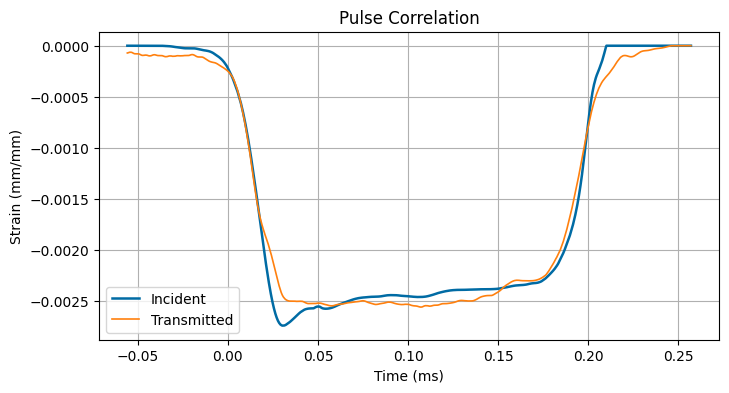

In [17]:
# --- 1.  Experiment-specific constants 
from importlib import reload, import_module
shift_opt = reload(import_module("shift_optimizer"))

bar_wave_speed = 4953.321                                                     # mm/ms  ← adjust per bar material 
specimen_length = spec_df.iloc[idx]["length_mm"].astype(np.float32)           # mm   ← from specimen metadata
specimen_length = 6.5
opt_weights = dict(corr=0.3, u=0.3, sr=0.3, e=0.10)                         # weights for the optimiser criteria

# --- 2.  Run the optimiser 
inc_aligned, tran_aligned, refl_aligned, best_shift_t, best_shift_r =  shift_optimizer(
        incident          = inc_seg,
        transmitted       = trs_seg,
        reflected         = ref_seg,
        time_vector       = time_seg,         # same length as *_seg
        bar_wave_speed    = bar_wave_speed,
        specimen_length   = specimen_length,
        k_linear          = 0.35,             # 30 % of steepest slope for linear idx
        search_bounds_t   = (1200,1800),        # for 12 in (600,850), for 18 in 
        search_bounds_r   = (-2800, -2400),   # for 12 in (-3000, -2000), for 18 in
        weights           = opt_weights,
        debug             = False
    )

print(f"optimal shifts  Transmitted = {best_shift_t:+d}  Reflected = {best_shift_r:+d}  [samples]")

# --- 3.  Build t-axis so t = 0 at the rise of the incident signal
front_thresh    = 0.08
inc_abs      = np.abs(inc_aligned)
front_idx    = np.argmax(inc_abs > front_thresh * inc_abs.max())
dt            = np.median(np.diff(raw_df["Time"]))   # sampling interval [s]
time_aligned  = (np.arange(n_pts) - front_idx) * dt      # centred on the rise front

# --- 4.  Visual check 
plt.figure(figsize=(8,4))
plt.plot(time_aligned, inc_aligned,  lw=1.8, label="Incident")
plt.plot(time_aligned, tran_aligned, lw=1.2, label="Transmitted")
plt.plot(time_aligned, refl_aligned, lw=1.2, label="Reflected", c = "green")
plt.axvline(0, ls="--", c="k", lw=0.8)               # t = 0 marker
plt.xlabel("Time (ms)")
plt.ylabel("Strain (mm/mm)")
plt.title("Aligned Pulses")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(time_aligned, inc_aligned,  lw=1.8, label="Incident")
plt.plot(time_aligned, tran_aligned - refl_aligned , lw=1.2, label="Transmitted")
plt.xlabel("Time (ms)")
plt.ylabel("Strain (mm/mm)")
plt.title("Pulse Correlation")
plt.legend()
plt.grid()
plt.show()


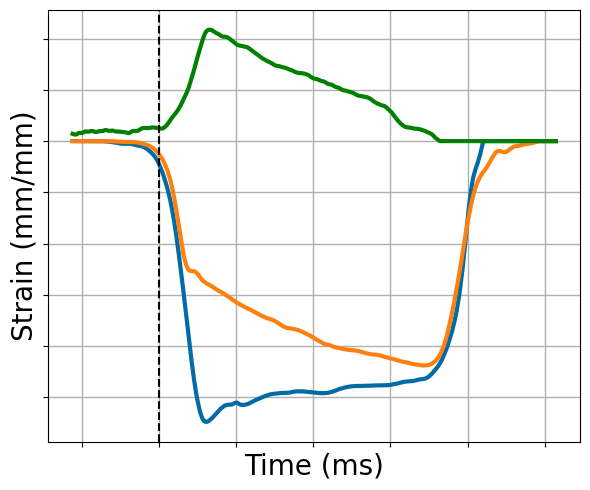

In [88]:
plt.figure(figsize=(6,5))
plt.plot(time_aligned, inc_aligned,  lw=3, label="Incident")
plt.plot(time_aligned, tran_aligned, lw=3, label="Transmitted")
plt.plot(time_aligned, refl_aligned, lw=3, label="Reflected", c = "green")
plt.axvline(0, ls="--", c="k", lw=1.5, label = "t(0)")               # t = 0 marker
plt.grid(lw=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.xlabel("Time (ms)", fontsize=20)
plt.ylabel("Strain (mm/mm)", fontsize=20)
#plt.title("Aligned Pulses")
#plt.legend(fontsize=18, bbox_to_anchor=(0.53, 0.68))
plt.tight_layout()
plt.savefig(r"D:\LaTex\W-Ta Proposal\figures\shpb_signals.png", dpi=300)
plt.show()

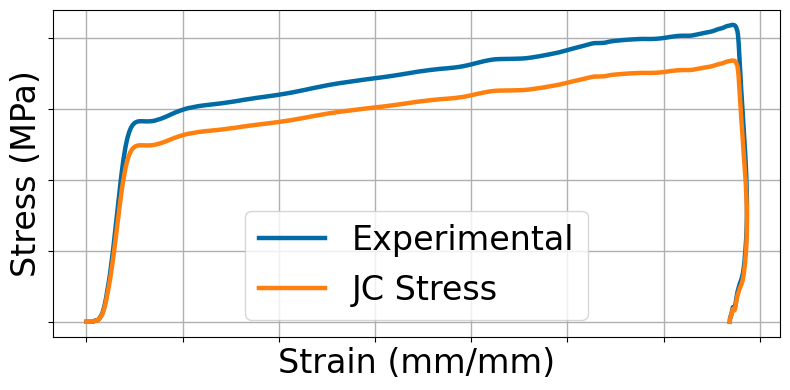

In [90]:
plt.figure(figsize=(8,4))
plt.plot(-true_strain_3W, -true_stress_1W*1e3, label = "Experimental", lw=3.2)
plt.plot(-true_strain_3W, -true_stress_1W*1e3*0.88, label = "JC Stress", lw =3.2)
plt.xlabel("Strain (mm/mm)", fontsize=24)
plt.ylabel("Stress (MPa)", fontsize=24)
plt.legend(fontsize=24)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.grid(lw =1)
plt.tight_layout()
plt.savefig(r"D:\LaTex\W-Ta Proposal\figures\pinn_signals.png", dpi=300)
plt.show()

## Post-Process Check
Analyze computed material response from aligned shifts, if agreement is met continue with the Tukey factors.

In [50]:
bar_cross_section = 71.26       # mm^2  ← adjust per bar dimension
bar_elastic_modulus = 199.99    # GPA  ← adjust per bar material
bar_wave_speed = 4953.321       # mm/ms  ← adjust per bar material

specimen_length = spec_df.iloc[idx]["length_mm"].astype(np.float32)    # mm   ← from specimen metadata
specimen_cross = spec_df.iloc[idx]["area_mm2"].astype(np.float32)      # mm2   ← from specimen metadata
t = time_aligned


### Bar Displacement
u2W = bar_wave_speed * (inc_aligned + refl_aligned)
u1W = bar_wave_speed * (tran_aligned)

### Bar Forces
F2W = bar_cross_section * (bar_elastic_modulus/1000) * (inc_aligned + refl_aligned)
F1W = bar_cross_section * (bar_elastic_modulus/1000) * (tran_aligned)

## Eng Strain Rate
strain_rate_3W = (bar_wave_speed / specimen_length) * (inc_aligned - refl_aligned - tran_aligned)
strain_rate_1W = (2*bar_wave_speed*refl_aligned) / specimen_length

true_strain_rate_3W = np.log(1 - strain_rate_3W)
true_strain_rate_1W = np.log(1 + strain_rate_1W)

## Eng Strain
strain_3W = (bar_wave_speed / specimen_length) * cumulative_trapezoid(
                (inc_aligned - refl_aligned - tran_aligned),
                t, initial=0)

strain_1W = ((2*bar_wave_speed) / specimen_length) * cumulative_trapezoid(
                refl_aligned,
                t, initial=0)

## Eng Stress 
sigma_2W = (bar_elastic_modulus/1000) * (bar_cross_section / specimen_cross) * (inc_aligned + refl_aligned)
sigma_1W = (bar_elastic_modulus/1000) * (bar_cross_section / specimen_cross) * (tran_aligned)

# True Stress True Strain Series
true_strain_3W = np.log(1 + strain_3W)
true_strain_1W = np.log(1 + strain_1W)
true_stress_2W = sigma_2W * (1 + strain_3W)
true_stress_1W = sigma_1W * (1 + strain_3W)

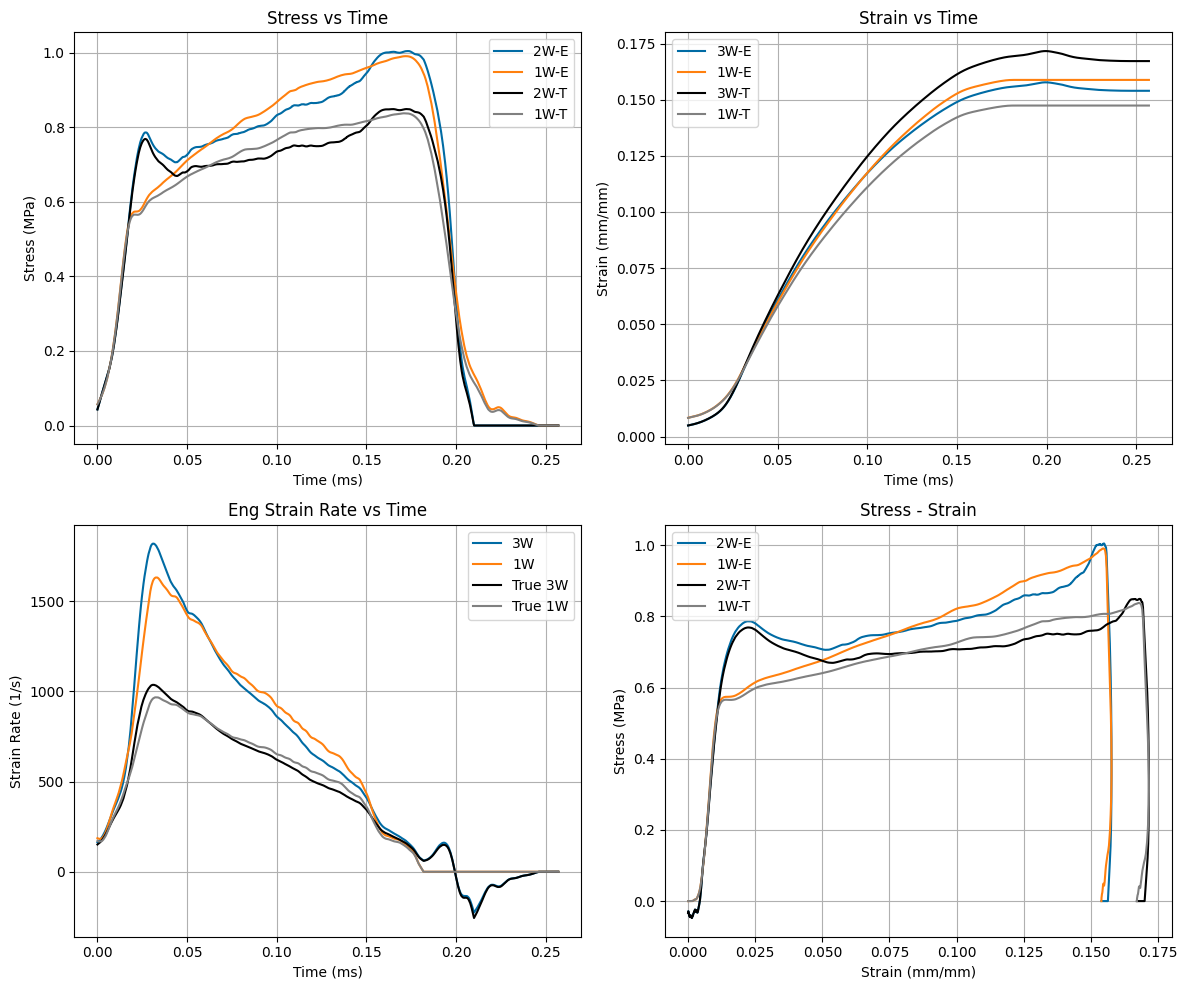

In [51]:
# Multi view plot, for precheck
t_init = np.argwhere(time_aligned==0)[0][0]
t_init

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))

ax1.plot(t[t_init:], -sigma_2W[t_init:]*1e3, label = "2W-E")
ax1.plot(t[t_init:], -sigma_1W[t_init:]*1e3, label = "1W-E")
ax1.plot(t[t_init:], -true_stress_2W[t_init:]*1e3, label = "2W-T", c = "black")
ax1.plot(t[t_init:], -true_stress_1W[t_init:]*1e3, label = "1W-T", c = "gray")
ax1.set_title("Stress vs Time")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Stress (MPa)")
ax1.legend()
ax1.grid()

ax2.plot(t[t_init:], -strain_3W[t_init:], label = "3W-E")
ax2.plot(t[t_init:], strain_1W[t_init:], label = "1W-E")
ax2.plot(t[t_init:], -true_strain_3W[t_init:], label = "3W-T", c = "black")
ax2.plot(t[t_init:], true_strain_1W[t_init:], label = "1W-T", c = "gray")
ax2.set_title("Strain vs Time")
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Strain (mm/mm)")
ax2.legend()
ax2.grid()

ax3.plot(t[t_init:], -strain_rate_3W[t_init:]*1000, label = "3W")
ax3.plot(t[t_init:], strain_rate_1W[t_init:]*1000, label = "1W")
ax3.plot(t[t_init:], true_strain_rate_3W[t_init:]*1000, label = "True 3W", c = "black")
ax3.plot(t[t_init:], true_strain_rate_1W[t_init:]*1000, label = "True 1W", c = "gray")
ax3.set_title("Eng Strain Rate vs Time")
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("Strain Rate (1/s)")
ax3.legend()
ax3.grid()

ax4.plot(-strain_3W, -sigma_2W*1e3,  label = "2W-E")
ax4.plot(-strain_3W, -sigma_1W*1e3, label = "1W-E")
ax4.plot(-true_strain_3W, -true_stress_2W*1e3, label = "2W-T", c = "black")
ax4.plot(-true_strain_3W, -true_stress_1W*1e3, label = "1W-T", c = "gray")
ax4.set_title("Stress - Strain")
ax4.set_xlabel("Strain (mm/mm)")
ax4.set_ylabel("Stress (MPa)")
ax4.legend()
ax4.grid()
plt.tight_layout()
plt.show()

## Compute Tukey Weights
Multiplies each pulse by a length‑dependent Tukey weight (α scaled with vector length)

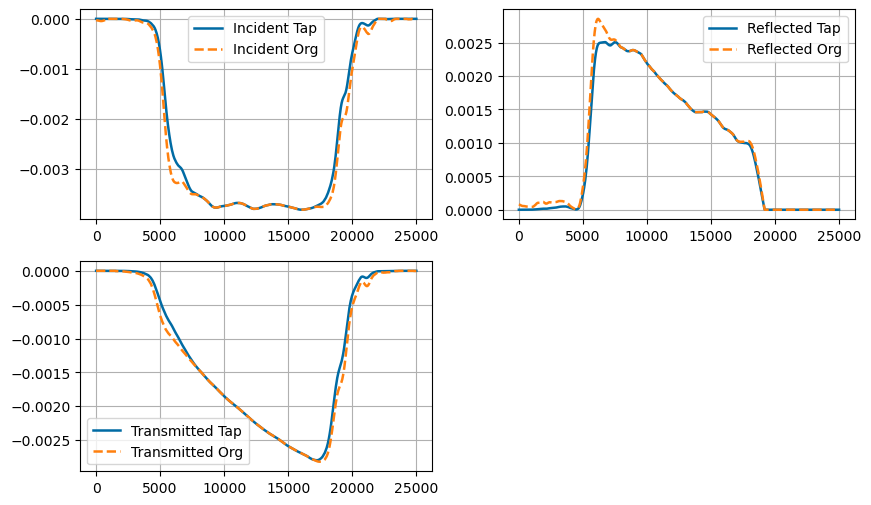

In [518]:
alpha = 0.65
window = tukey(n_pts, alpha)           # precompute once

inc_tapered  = inc_aligned  * window
refl_tapered = refl_aligned * window
tran_tapered = tran_aligned * window
fig, ax = plt.subplots(2,2, figsize=(10,6))

ax[0,0].plot(inc_tapered,  lw = 1.8,  label="Incident Tap")
ax[0,0].plot(inc_aligned, lw = 1.8,  label= "Incident Org", ls="--")
ax[0,0].legend()
ax[0,0].grid()

ax[0,1].plot(refl_tapered, lw = 1.8,  label="Reflected Tap")
ax[0,1].plot(refl_aligned, lw = 1.8,  label= "Reflected Org", ls="--")
ax[0,1].legend()
ax[0,1].grid()

ax[1,0].plot(tran_tapered, lw = 1.8,  label="Transmitted Tap")
ax[1,0].plot(tran_aligned, lw = 1.8,  label= "Transmitted Org", ls="--")
ax[1,0].legend()
ax[1,0].grid()

ax[1, 1].set_visible(False)  # Hide the bottom-right subplot
plt.show()


## Build the npz Training File
Bundles all arrays and metadata into one npz file per UID.

In [519]:
today = datetime.now().date()

geo = spec_df.iloc[idx]      # length_mm, area_mm2, diameter_mm for specific test

sample = dict(
    uid             = targets[idx].stem,             
    time            = time_aligned.astype(np.float32),
    incident_raw    = inc_aligned.astype(np.float32),
    reflected_raw   = refl_aligned.astype(np.float32),
    transmitted_raw = tran_aligned.astype(np.float32),

    incident_weight = inc_tapered.astype(np.float32), 
    reflected_weight = refl_tapered.astype(np.float32),
    transmitted_weight = tran_tapered.astype(np.float32),    

    # --- specimen geometry ---
    L0_mm        = np.float32(geo["length_mm"]),
    A0_mm2       = np.float32(geo["area_mm2"]),
    D0_mm        = np.float32(geo["diameter_mm"]),            

    # --- useful tags for later filtering / plots ---
    material    = targets[idx].stem.split("_")[2],
    processing  = "3DPrinted",
    test_mode   = targets[idx].stem.split("_")[3],
    test_date   = targets[idx].stem.split("_")[1], 
    test_temperature = targets[idx].stem.split("_")[4],
    test_id = targets[idx].stem.split("_")[5]
)

npz_path = out_dir / f"{sample['uid']}.npz"
np.savez_compressed(npz_path, **sample)     # <-- single-line save


## Append to npz_metadata
Append the metadata info to the global 

In [520]:
meta_row = {
    "uid":              sample["uid"],
    "npz_path":         str(npz_path),
    "material":         sample["material"],
    "test_id":          sample["test_id"],
    "processing":       sample["processing"],
    "test_mode":        sample["test_mode"],    
    "test_temperature": sample["test_temperature"],
    "test_date":        sample["test_date"],
    "L0_mm":            sample["L0_mm"],
    "A0_mm2":           sample["A0_mm2"],
    "D0_mm":            sample["D0_mm"],
    "n_points":         len(sample["time"]),
    "alpha_tukey":      alpha,
    "processed":        today 
}

meta_csv = Path("../pinn_dataset/npz_metadata.csv")
if meta_csv.exists():
    # append without loading the whole file – one-line mode
    meta_csv_open = meta_csv.open("a", newline="")
    pd.DataFrame([meta_row]).to_csv(meta_csv_open, header=False, index=False)
    meta_csv_open.close()
else:
    # first experiment – write header
    pd.DataFrame([meta_row]).to_csv(meta_csv, header=True, index=False)